In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt 
from sklearn.linear_model import LinearRegression

In [3]:
data = pd.read_csv("../data/DataWithLocationCleaned.zip")
data.head()

,Port Name,State,Port Code,Border,Date,Measure,Value,position
0,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Full,133,"(48.905266, -95.314404)"
1,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Truck Containers Empty,298,"(48.905266, -95.314404)"
2,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicles,10383,"(48.905266, -95.314404)"
3,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Personal Vehicle Passengers,19459,"(48.905266, -95.314404)"
4,Warroad,Minnesota,3423,US-Canada Border,2019-06-01,Pedestrians,2,"(48.905266, -95.314404)"


In [8]:
g1 = data.groupby(['Date','Measure'])[['Value']].sum().reset_index()
g1.head()

,Date,Measure,Value
0,1996-01-01,Bus Passengers,299911
1,1996-01-01,Buses,17873
2,1996-01-01,Pedestrians,3138859
3,1996-01-01,Personal Vehicle Passengers,20181055
4,1996-01-01,Personal Vehicles,7711801


In [10]:
g2 = data.groupby(['Date','Port Name'])[['Value']].sum().reset_index()
g2.head()

,Date,Port Name,Value
0,1996-01-01,Alcan,3416
1,1996-01-01,Alexandria Bay,127628
2,1996-01-01,Ambrose,1598
3,1996-01-01,Andrade,428954
4,1996-01-01,Antler,2526


In [12]:
g2.shape[0]

30598

In [15]:
data.groupby('Port Name')['Value'].sum().reset_index().max()
#Willow Creek is the port with the most influence between the years. Let's do a regression in order to regress the influence

Port Name    Willow Creek
Value          1160786864
dtype: object

In [26]:
g3 = g2[(g2['Port Name'] == 'Willow Creek') & (g2['Value'] != 0)].reset_index(drop=True)
g3.head()

,Date,Port Name,Value
0,2005-04-01,Willow Creek,272
1,2005-05-01,Willow Creek,475
2,2005-06-01,Willow Creek,617
3,2005-07-01,Willow Creek,1016
4,2005-08-01,Willow Creek,1061


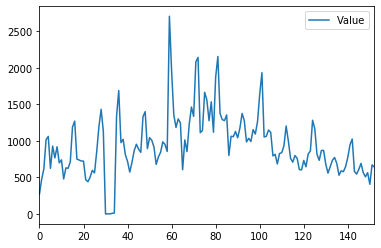

In [28]:
g3.set_index(['Date'], drop=True)
g3.plot()

In [29]:
data.dtypes

Port Name    object
State        object
Port Code     int64
Border       object
Date         object
Measure      object
Value         int64
position     object
dtype: object

In [30]:
data['Date'] = pd.to_datetime(data['Date'])

In [31]:
#We have to consider 2 types of regression : 
#          : 1) One for the traffic at the port
#                  -> use only 'Buses' , 'Personal Vehicles' , 'Rail Containers Empty' , 'Rail Containers Full', 'Trains' , 'Truck Containers Empty' , 'Truck Containers Full' and 'Trucks'
#          : 2) One for the number of persons crossing the port ("immigration")
#                  -> use only 'Bus passengers', 'Pedestrians', 'Personal Vehicle Passengers' and 'Train Passengers'

data.groupby("Measure")[['Value']].sum().reset_index()

,Measure,Value
0,Bus Passengers,143388212
1,Buses,8604318
2,Pedestrians,1056699751
3,Personal Vehicle Passengers,5504073464
4,Personal Vehicles,2584776249
5,Rail Containers Empty,21477185
6,Rail Containers Full,38891558
7,Train Passengers,6287351
8,Trains,912969
9,Truck Containers Empty,64852271


In [32]:
#Create 2 DataFrame : one for the traffic at the ports and one for the persons crossing the ports
persons = data[data['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers'])].reset_index().drop(columns=['index'])
traffic = data[~data['Measure'].isin(['Bus Passengers','Pedestrians','Personal Vehicle Passengers','Train Passengers','Truck Containers Empty','Truck Containers Full'])].reset_index().drop(columns=['index'])

In [33]:
#We create a new column named ordinalDate containing the date in ordinal value
#Regression cannot be done on dates.
persons['ordinalDate']=persons['Date'].map(dt.datetime.toordinal)

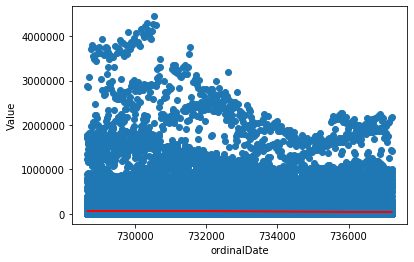

In [35]:
#Linear Regression with all the values
X = persons[["ordinalDate"]]
y = persons["Value"]

model = LinearRegression()
model.fit(X,y)
predictions = model.predict(X)

plt.scatter(X.iloc[:,0], y)
plt.plot(X.iloc[:,0], predictions, 'r')
plt.xlabel(X.columns[0])
plt.ylabel('Value')
plt.show()

In [48]:
# We can see that regression isn't working well because a lot of value are equal to 0.
# So, instead we
personsSumDay = persons.groupby("ordinalDate")[['Value']].sum().reset_index()
personsSumDay.head()

,ordinalDate,Value
0,728659,23633628
1,728690,23423798
2,728719,25759922
3,728750,26211553
4,728780,27444210


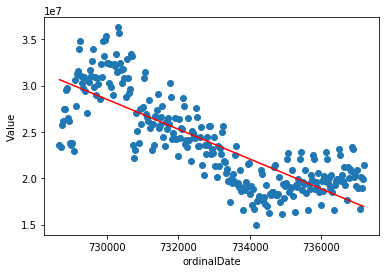

In [49]:
X = personsSumDay[["ordinalDate"]]
y = personsSumDay["Value"]

model = LinearRegression()
model.fit(X,y)
predictions = model.predict(X)

plt.scatter(X.iloc[:,0], y)
plt.plot(X.iloc[:,0], predictions, 'r')
plt.xlabel(X.columns[0])
plt.ylabel('Value')
plt.show()

# There is too few values -> not very interesting
# Let's focus on only one Border 

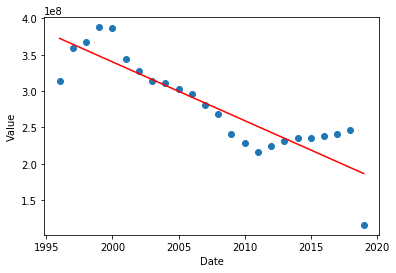

In [38]:
personsSumYear = persons.groupby(persons['Date'].dt.year)[['Value']].sum().reset_index()
X = personsSumYear[["Date"]]
y = personsSumYear["Value"]

model = LinearRegression()
model.fit(X,y)
predictions = model.predict(X)

plt.scatter(X.iloc[:,0], y)
plt.plot(X.iloc[:,0], predictions, 'r')
plt.xlabel(X.columns[0])
plt.ylabel('Value')
plt.show()

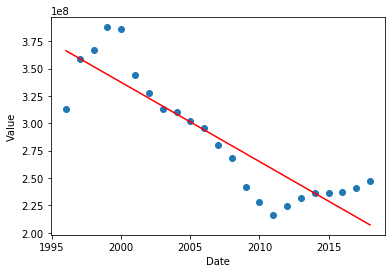

In [62]:
#The year 2019 is a biaised because there is still missing informations. We will take the value out and regress again
personsSumYear = personsSumYear[personsSumYear['Date'] != 2019]
X = personsSumYear[["Date"]]
Y = personsSumYear["Value"]

model = LinearRegression()
model.fit(X,y)
predictions = model.predict(X)

plt.scatter(X.iloc[:,0], Y)
plt.plot(X.iloc[:,0], predictions, 'r')
plt.xlabel(X.columns[0])
plt.ylabel('Value')
plt.show()


In [64]:
mae = mean_absolute_error(predictions, y)
print("MAE = %.2f" % mae)

MAE = 19256371.63


In [59]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, Y, random_state=1)
# Specify the model
iowa_model = LinearRegression()

# Fit the model with the *TRAINING* data
iowa_model.fit(train_X, train_y)

# Predict with all validation observations
val_predictions = iowa_model.predict(val_X)

In [73]:
from sklearn.metrics import mean_absolute_error
val_mae = mean_absolute_error(val_predictions, val_y)
print("Val MAE = %.2f" % val_mae)

Val MAE = 22950876.84


In [51]:
nn = persons[['Date','Value']]
nn = persons.groupby("Date")[['Value']].sum().reset_index()
nn.head()

,Date,Value
0,1996-01-01,23633628
1,1996-02-01,23423798
2,1996-03-01,25759922
3,1996-04-01,26211553
4,1996-05-01,27444210


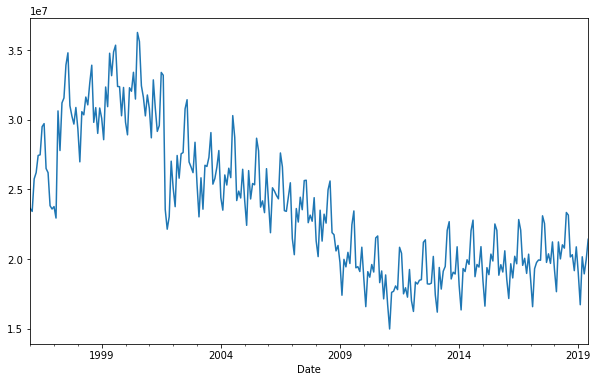

In [52]:
nn['Date'] = pd.to_datetime(nn['Date'])
nn = nn.set_index(['Date'], drop=True)
nn = nn.sort_index()
plt.figure(figsize=(10, 6))
nn['Value'].plot();

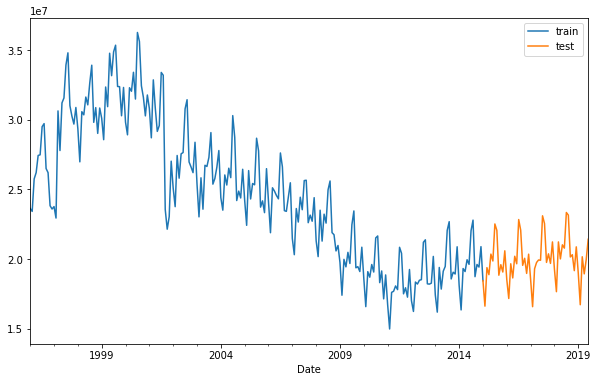

In [53]:
split_date = pd.Timestamp('2015-01-01')
df =  nn['Value']
train = df.loc[:split_date]
test = df.loc[split_date:]
plt.figure(figsize=(10, 6))
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test']);